<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo)
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [75]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    'axes.spines.top': False,       # Turn off top spine
    'axes.spines.right': False
}) # Turn off right spine
import collections
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import Image
from io import StringIO

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

#### Creating the dataset

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

#### Training data

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)

df = df_train.copy()

df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Looks_handsome,Looks_repulsive,Eloquence_average,Alcoholic_beverage_yes,Alcoholic_beverage_no,Money_spent_lots,Money_spent_little
0,1,1,0,0,1,0,1,0
1,0,1,0,0,1,0,0,1
2,0,1,0,1,0,1,1,0
3,0,0,1,1,0,1,0,1
4,0,0,1,0,1,0,1,0
5,1,0,1,0,1,0,1,0
6,0,1,0,1,1,0,1,0


In [7]:
df_test

,Eloquence_high,Looks_handsome,Looks_repulsive,Eloquence_average,Alcoholic_beverage_yes,Alcoholic_beverage_no,Money_spent_lots,Money_spent_little
0,0,1,0,1,0,1,1,0
1,1,1,0,0,1,0,0,1
2,0,0,1,1,1,0,1,0


#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

#### 1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

Entropy formula: 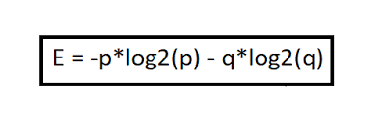

In [8]:
class_counts = df["Will_go"].value_counts()
total_instances = len(df)
p_class_0 = class_counts[0] / total_instances
p_class_1 = class_counts[1] / total_instances

entropy = -p_class_0 * np.log2(p_class_0) - p_class_1 * np.log2(p_class_1)

print("Entropy:", entropy)

Entropy: 0.9852281360342515


In [9]:
from math import log2

term1 = -(3/7) * log2(3/7)
term2 = -(4/7) * log2(4/7)

entropy = term1 + term2
print(entropy)

0.9852281360342516


Answer: The answer is entropy $S_0$ of the initial system is 0.985

#### 2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

In [10]:
# Function to calculate Entropy (S)
def calculate_entropy(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    class_probabilities = class_counts / len(y)
    entropy = -np.sum(class_probabilities * np.log2(class_probabilities))
    return entropy

# Function to calculate Information Gain (IG)
def calculate_information_gain(y_original, y_group1, y_group2):
    entropy_original = calculate_entropy(y_original)
    entropy_group1 = calculate_entropy(y_group1)
    entropy_group2 = calculate_entropy(y_group2)
    
    p_group1 = len(y_group1) / len(y_original)
    p_group2 = len(y_group2) / len(y_original)
    
    weighted_avg_entropy = (entropy_group1 * p_group1) + (entropy_group2 * p_group2)
    
    information_gain = entropy_original - weighted_avg_entropy
    return information_gain

# Split the data based on "Looks_handsome"
y_original = df["Will_go"]
y_group1 = df[df["Looks_handsome"] == 1]["Will_go"]
y_group2 = df[df["Looks_handsome"] == 0]["Will_go"]

# Calculate information gain
information_gain = calculate_information_gain(y_original, y_group1, y_group2)

print("Information Gain:", information_gain)

Information Gain: 0.12808527889139443


In [11]:
df[['Will_go','Looks_handsome']].sort_values(by='Looks_handsome', ascending=False)

,Will_go,Looks_handsome
0,0,1
1,1,1
2,0,1
6,0,1
3,1,0
4,1,0
5,0,0


In [12]:
print(f"Entropy (S1) = {- (1/4) * log2(1/4) - (3/4) * log2(3/4) :.3f}")

Entropy (S1) = 0.811


In [13]:
print(f"Entropy (S2) = {- (2/3) * log2(2/3) - (1/3) * log2(1/3):.3f}")

Entropy (S2) = 0.918


In [14]:
print(f"Original Entropy (S) = {- (4/7) * log2(4/7) - (3/7) * log2(3/7):.3f}")

Original Entropy (S) = 0.985


In [15]:
0.985 - (0.463 + 0.394)

0.128

Answer: 

Split the data based on the feature "Looks_handsome" to see how it affects the "Will_go" decision.

### <u> **Step 1: Calculate Entropy**<u> 

    Entropy measures the disorder or randomness in a set of data. For each group (those with "Looks_handsome" and those without), we'll calculate the entropy of the "Will_go" column:

    Entropy (S1) for the group with "Looks_handsome" (Looks_handsome = 1):
    - Number of samples: 4 (rows 0, 1, 2, and 6)
    - Number of positive outcomes (Will_go=1): 1
    - Number of negative outcomes (Will_go=0): 3
    - Entropy (S1) = - (1/4) * log2(1/4) - (3/4) * log2(3/4) = 0.811

    Entropy (S2) for the group without "Looks_handsome" (Looks_handsome = 0):
    - Number of samples: 3 (rows 3, 4, and 5)
    - Number of positive outcomes (Will_go=1): 2
    - Number of negative outcomes (Will_go=0): 1
    - Entropy (S2) = - (2/3) * log2(2/3) - (1/3) * log2(1/3) ≈ 0.918

### <u> **Step 2: Calculate Information Gain**<u> 

    Information Gain (IG) measures how much splitting the data by a certain feature reduces the overall entropy. It is calculated as the difference between the original entropy and the weighted average of the entropies of the resulting groups.

    Original Entropy (S):
    - Number of samples: 7
    - Number of positive outcomes (Will_go=1): 4
    - Number of negative outcomes (Will_go=0): 3
    - Entropy (S) = - (4/7) * log2(4/7) - (3/7) * log2(3/7) ≈ 0.985

    Weighted Average of Entropies:
    - Weighted Entropy (S1): (4/7) * Entropy (S1) ≈ 0.463
    - Weighted Entropy (S2): (3/7) * Entropy (S2) ≈ 0.394

    Information Gain (IG) = Entropy (S) - (Weighted Entropy (S1) + Weighted Entropy (S2)) ≈ 0.985 - (0.463 + 0.394) ≈ 0.128

Conclusion:
The Information Gain (IG) resulting from splitting the data by the "Looks_handsome" feature is approximately 0.128. This value represents the reduction in entropy achieved by making this split, and it helps us understand how well the "Looks_handsome" feature separates the data into more homogeneous groups based on the "Will_go" outcome.

#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [16]:
tree = DecisionTreeClassifier(random_state=42, max_depth=10, criterion="entropy")
tree.fit(df_train, y)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

#### Additional: display the resulting tree using graphviz. You can use pydot or [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

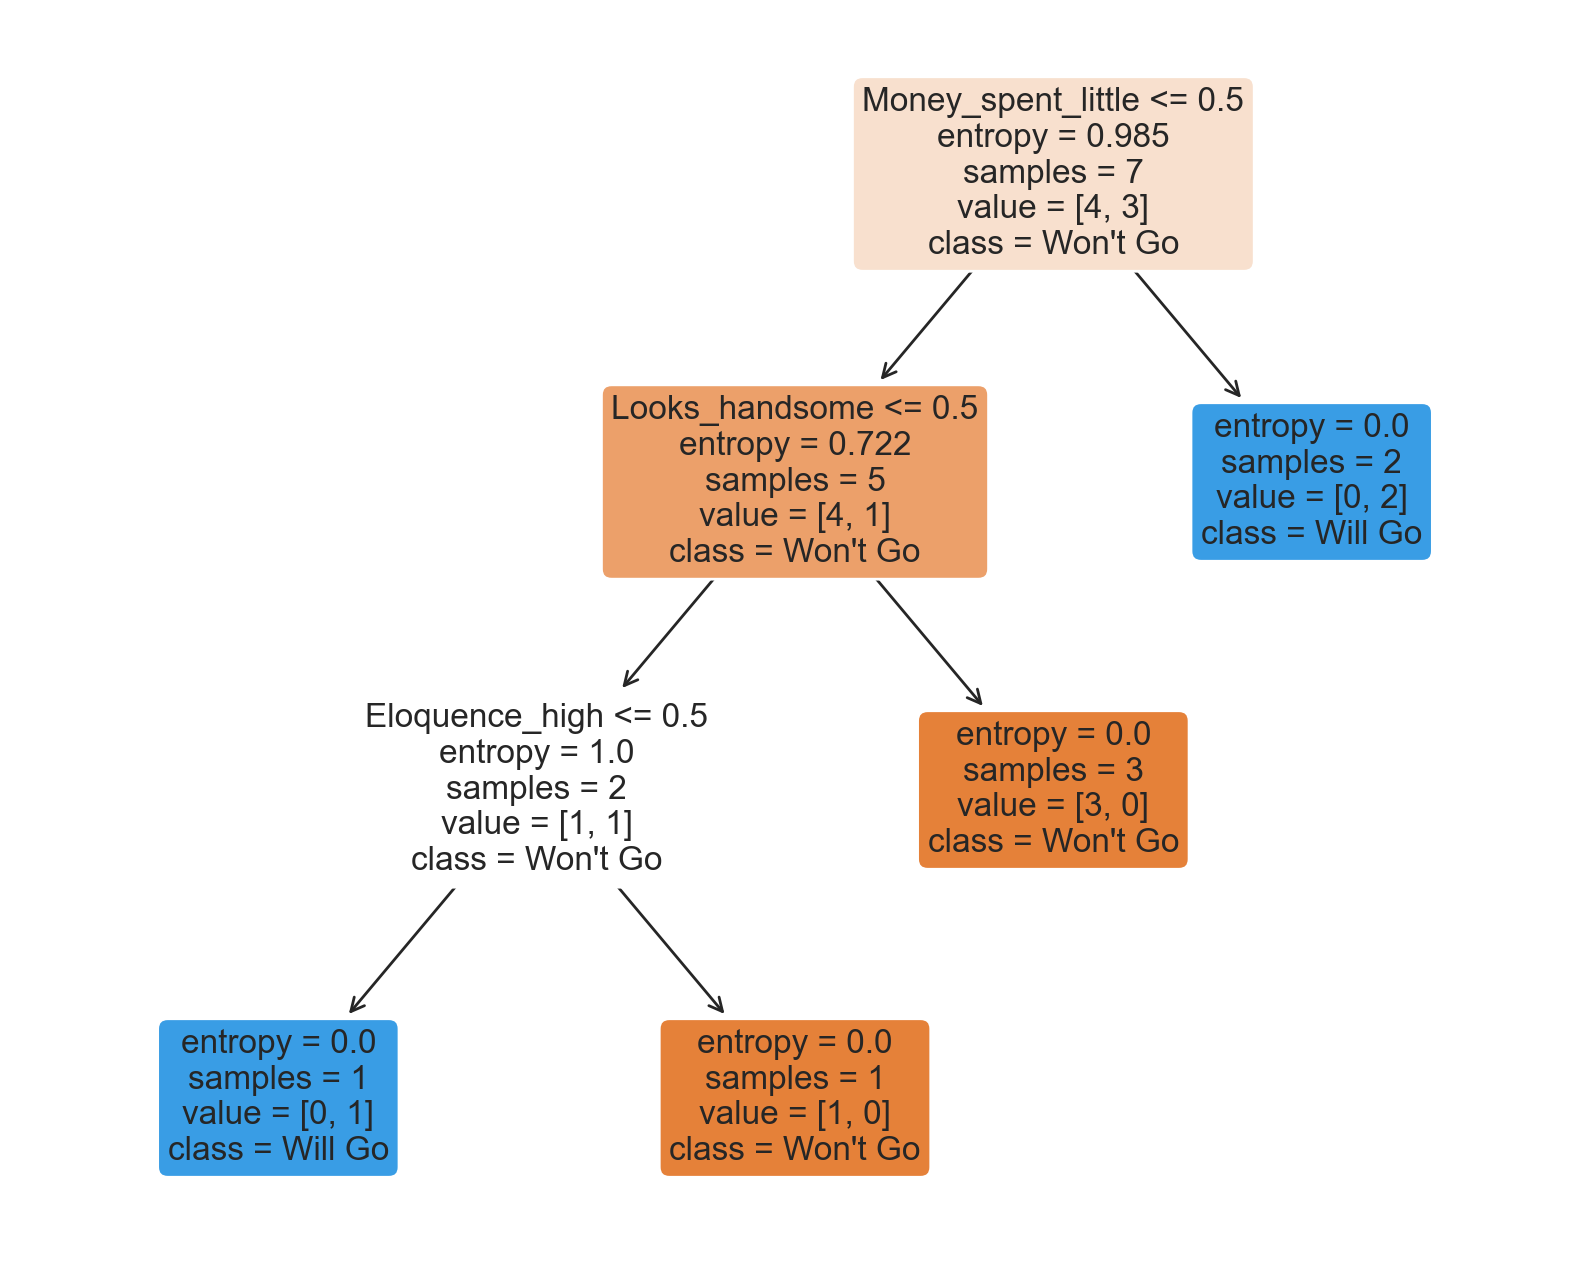

In [17]:
plt.figure(figsize=(10,8))

plot_tree(tree, 
          feature_names = df_train.columns.to_list(), 
          filled=True, 
          rounded=True, 
          class_names =["Won't Go", 'Will Go'],
          fontsize=12);

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label **1** if it is blue, **0** otherwise.

In [18]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<img src = 'https://habrastorage.org/webt/mu/vl/mt/muvlmtd2njeqf18trbldenpqvnm.png'>

Next split the balls into two groups:

<img src='https://habrastorage.org/webt/bd/aq/5w/bdaq5wi3c4feezaexponvin8wmo.png'>

In [19]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

This only apply to 2 groups only:

In [20]:
def entropy(a_list):
    unique_classes, class_counts = np.unique(a_list, return_counts=True)
    p1 = class_counts[0]/len(a_list)
    p2 = class_counts[1]/len(a_list)
    entropy = - (p1*np.log2(p1)) - (p2*np.log2(p2)) # only 2 groups
    return entropy

Revised on my way:

In [21]:
def entropy(a_list):
    entropy = []
    unique_classes, class_counts = np.unique(a_list, return_counts=True)
    for c in class_counts:
        p = c / len(a_list)
        entropy.append(-(p * np.log2(p)))
    entropies = np.sum(entropy, axis=0)
    return entropies

In [22]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


Right way to conduct:

In [23]:
def entropy(a_list):
    unique_classes, class_counts = np.unique(a_list, return_counts=True)
    probabilities = class_counts / len(a_list)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

Tests

In [24]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


#### 3\. What is the entropy of the state given by the list **balls_left**?

Answer: Entropy of the state given by the list `balls_left` is 0.961

#### 4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

Answer: Entropy of a fair dice is 2.585

In [25]:
# information gain calculation
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
    
    ig = entropy(root) - (
        (len(left)/len(root) * entropy(left)) + 
        (len(right)/len(root)*entropy(right))
    )
    return ig

#### 5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

In [26]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

Answer: The Information gain from Splitting the `balls` into `balls_left` and `balls_right` is 0.16

In [27]:
def best_feature_to_split(X, y):
    '''Outputs information gain when splitting on best feature'''
    result = []
    
    for col in X.columns:
        result.append({
            'Feature': col, 
            'Information Gain': information_gain(y, y[X[col] == 0], y[X[col] == 1])
        })
    return pd.DataFrame(result).sort_values(by='Information Gain', ascending=False)

In [28]:
best_feature_to_split(df_train, y)

,Feature,Information Gain
6,Money_spent_lots,0.469565
7,Money_spent_little,0.469565
0,Eloquence_high,0.291692
1,Looks_handsome,0.128085
2,Looks_repulsive,0.128085
3,Eloquence_average,0.020244
4,Alcoholic_beverage_yes,0.005978
5,Alcoholic_beverage_no,0.005978


#### Optional:
- Implement a decision tree building algorithm by calling **best_feature_to_split** recursively
- Plot the resulting tree

In [29]:
def tree_info(X, y):
    """Outputs information gain when splitting with each feature"""
    result = []
    
    for col in X.columns:
        x_left = X[X[col] == 0]
        x_right = X[X[col] == 1]
        
        y_left = y[X[col] == 0]
        y_right = y[X[col] == 1]
        
        entropy_left = entropy(y_left)
        entropy_right = entropy(y_right)
        
        result.append({
            'Feature': col, 
            'Information Gain': information_gain(y, y_left, y_right),
            'Sample (Left)': len(x_left),
            'Sample (Right)': len(x_right),
            'Entropy (Left)': entropy_left,
            'Entropy (Right)': entropy_right
        })
    
    return pd.DataFrame(result).sort_values(by='Information Gain', ascending=False)


In [30]:
tree_info(df_train, y)

,Feature,Information Gain,Sample (Left),Sample (Right),Entropy (Left),Entropy (Right)
6,Money_spent_lots,0.469565,2,5,-0.000000,0.721928
7,Money_spent_little,0.469565,5,2,0.721928,-0.000000
0,Eloquence_high,0.291692,5,2,0.970951,-0.000000
1,Looks_handsome,0.128085,3,4,0.918296,0.811278
2,Looks_repulsive,0.128085,4,3,0.811278,0.918296
3,Eloquence_average,0.020244,4,3,1.000000,0.918296
4,Alcoholic_beverage_yes,0.005978,2,5,1.000000,0.970951
5,Alcoholic_beverage_no,0.005978,5,2,0.970951,1.000000


### Part 3. The "Adult" dataset

#### Dataset description:

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:

- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Reading train and test data

In [31]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")

In [32]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [33]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")

In [34]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [35]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

#### Primary data analysis

In [36]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_train['Target'].value_counts().to_frame()

,Target
0,24720
1,7841


In [38]:
data_train['Target'].value_counts(normalize=True).to_frame()

,Target
0,0.75919
1,0.24081


In [39]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [40]:
numeric_columns = data_train.select_dtypes(include=['int', 'float']).columns
print(f"Total of {len(numeric_columns)} cols: \n{numeric_columns.values}")

Total of 6 cols: 
['Age' 'fnlwgt' 'Education_Num' 'Capital_Gain' 'Capital_Loss'
 'Hours_per_week']


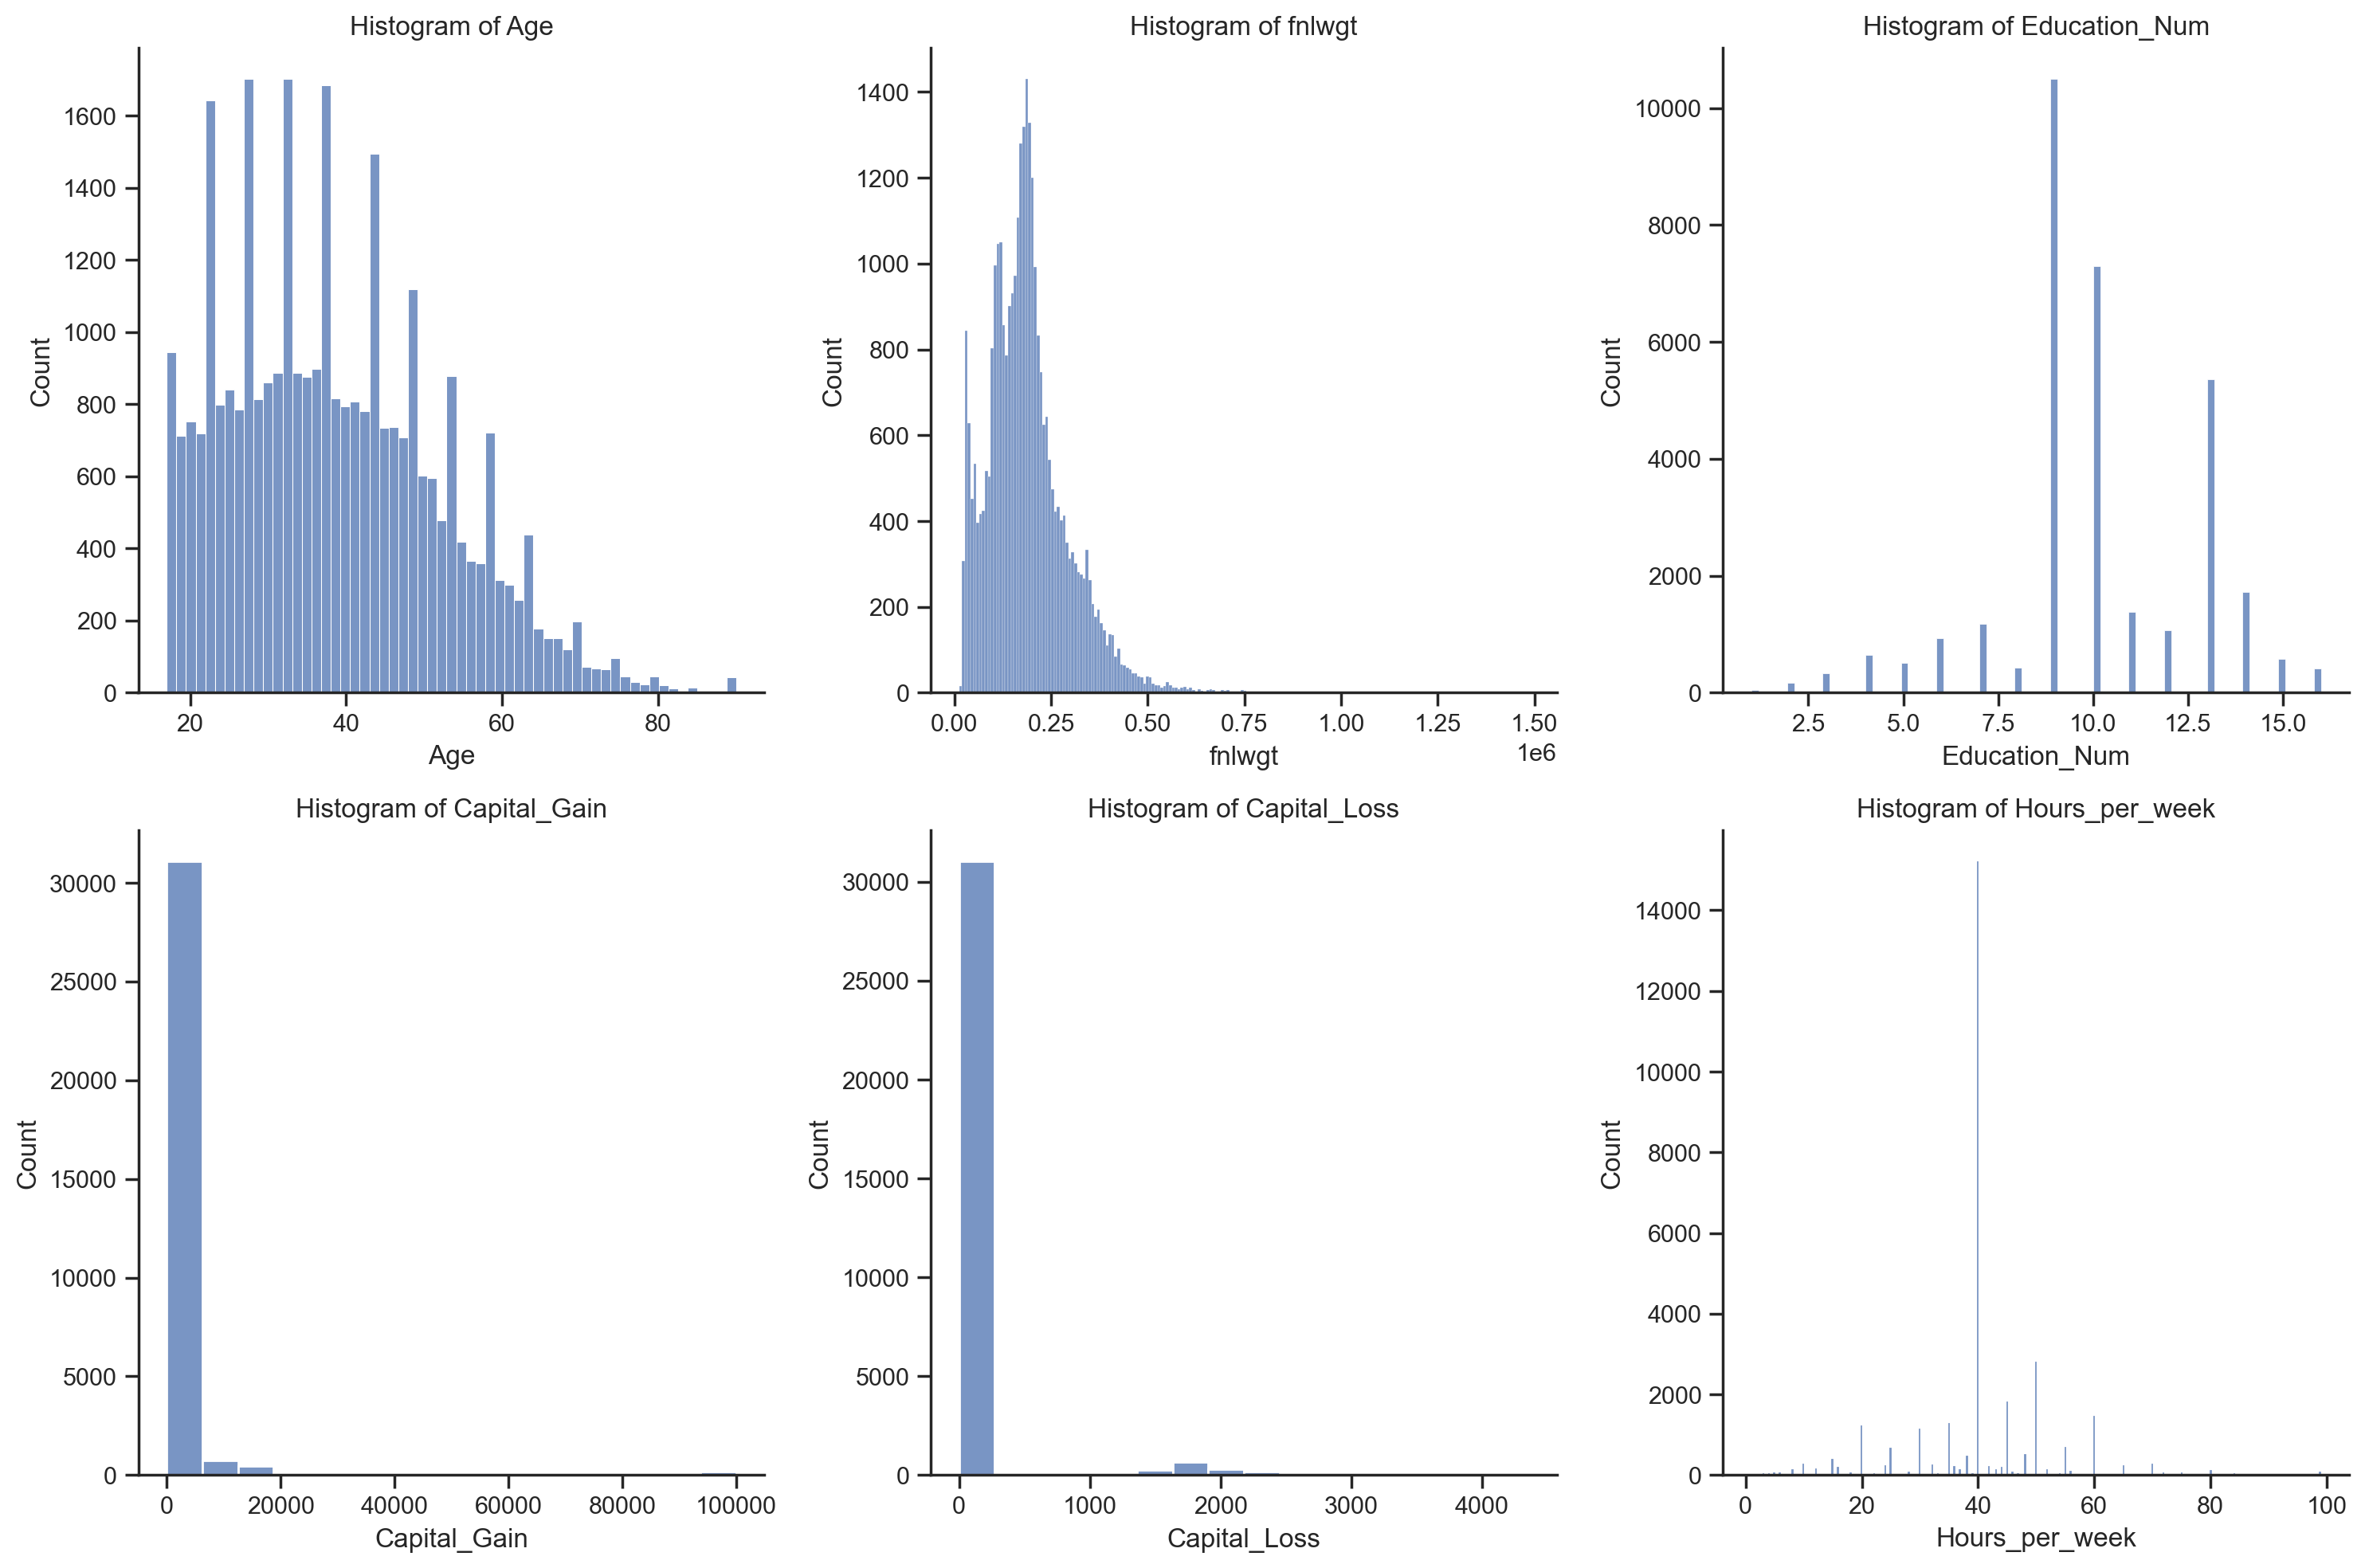

In [41]:
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 3 + 1

_, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

for i, col in enumerate(numeric_columns):
    sns.histplot(data=data_train, x=col, ax=axes[i // 3, i % 3]).set(title=f"Histogram of {col}")

plt.tight_layout();

In [42]:
category_columns = data_train.select_dtypes(include=['object', 'category']).columns
print(f"Total of {len(category_columns)} cols: \n{category_columns.values}")

Total of 9 cols: 
['Workclass' 'Education' 'Martial_Status' 'Occupation' 'Relationship'
 'Race' 'Sex' 'Country' 'Target']


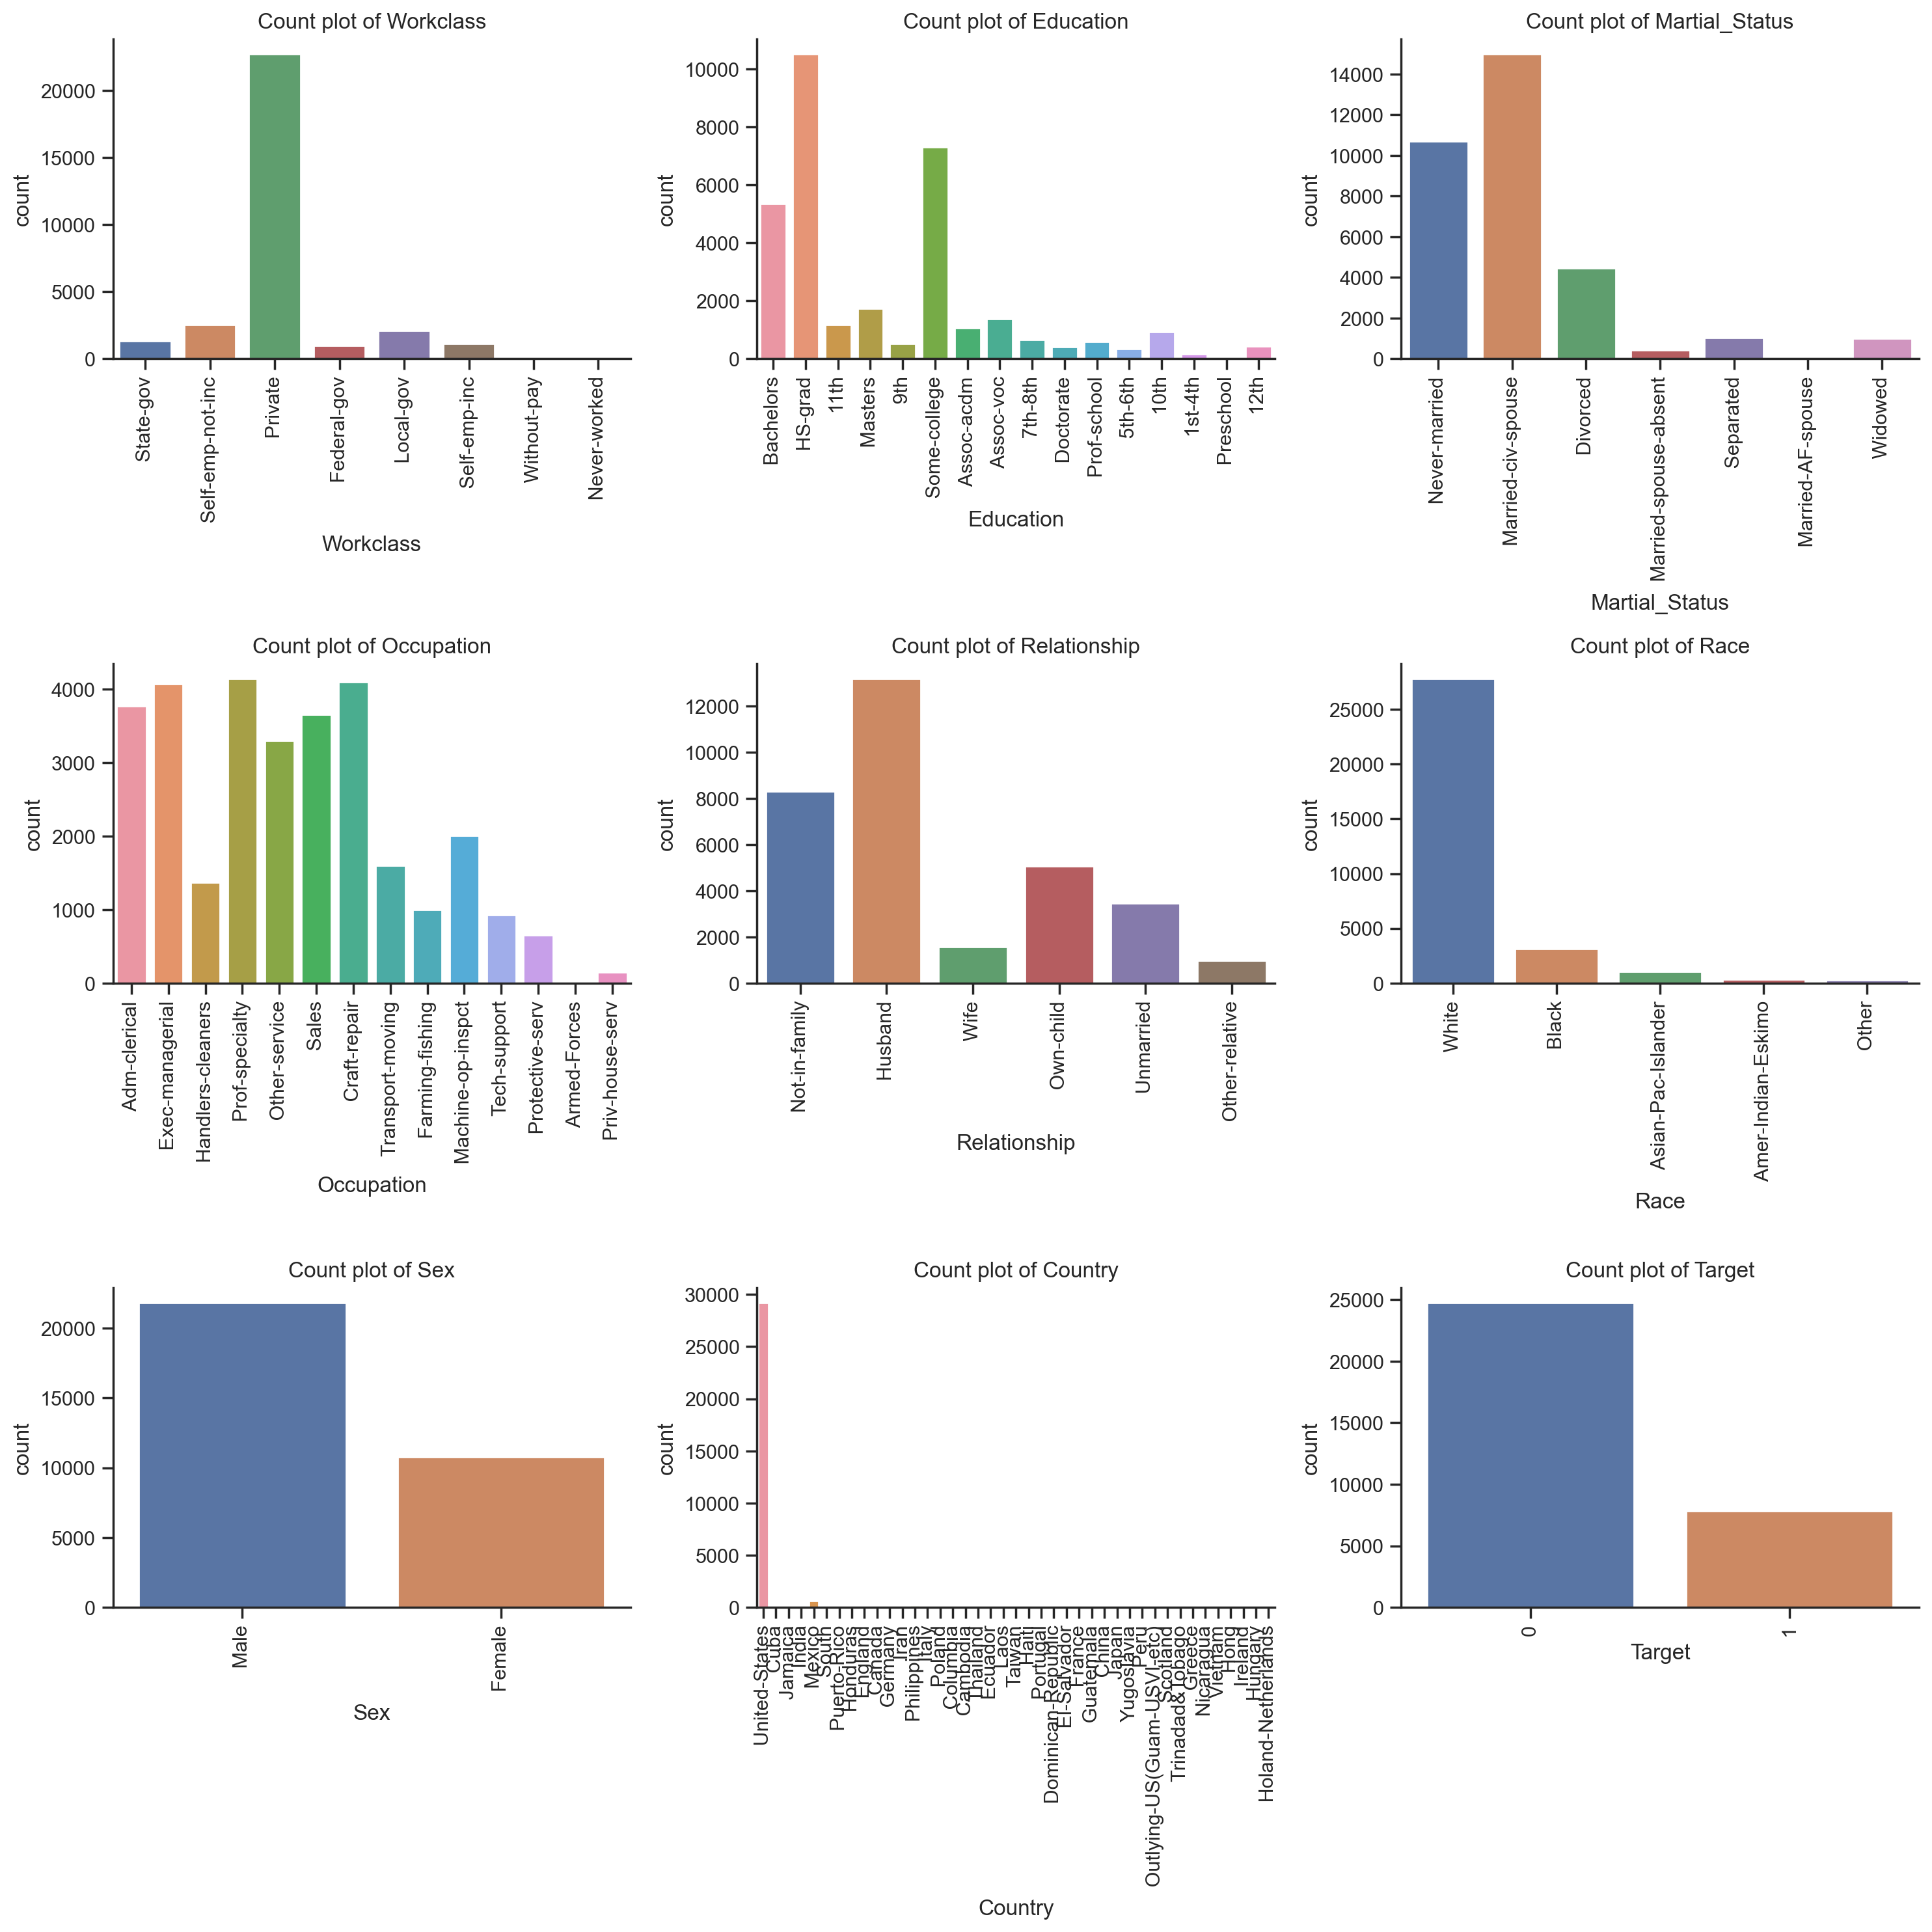

In [43]:
num_cols = len(category_columns)
num_rows = (num_cols - 1) // 3 + 1

_, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

for i, col in enumerate(category_columns):
    sns.countplot(data=data_train, x=col, ax=axes[i // 3, i % 3]).set(title=f"Count plot of {col}")
    axes[i // 3, i % 3].set_xticklabels(axes[i // 3, i % 3].get_xticklabels(), rotation=90)

plt.tight_layout();

#### Checking data types

In [44]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [45]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [46]:
data_test['Age'] = data_test['Age'].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [47]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

In [48]:
# same for the target
data_train["Target"] = data_train["Target"].astype(int)
data_test["Target"] = data_test["Target"].astype(int)

In [50]:
y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [52]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [53]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [54]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [55]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**

In [56]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [57]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [58]:
data_train.shape, data_test.shape

((32561, 105), (16281, 104))

#### There is no Holland in the test data. Create new zero-valued feature.

In [59]:
data_test['Country_ Holand-Netherlands'] = 0

In [60]:
set(data_train.columns) - set(data_test.columns)

set()

In [61]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [63]:
X_train = data_train
X_test = data_test

In [64]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32561, 105), (16281, 105), (32561,), (16281,))

### 3.1 Decision tree without parameter tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [65]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

Make a prediction with the trained model on the test data.

In [67]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [68]:
tree_predictions = tree.predict(X_test)

In [73]:
def get_score(model_name, y_true, y_pred):
    
    pre = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    score = pd.DataFrame([{
        "Model":model_name,
        'Precision':pre,
        "Recall": recall,
        "F1": f1,
        'Accuracy': acc
    }])
    
    return round(score,3)

score = get_score('Decision Tree', y_test, tree_predictions)
score

,Model,Precision,Recall,F1,Accuracy
0,Decision Tree,0.756,0.507,0.607,0.845


#### 6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

Answer: The accuracy for a decision tree with maximum tree depth of 3 and random_state = 17 is  0.845

### 3.2 Decision tree with parameter tuning

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [80]:
tree_params = {
    'max_depth': range(2,11),
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [2,5,10], 
    'max_features': [None, 0.5, 0.9]
}

locally_best_tree = GridSearchCV(tree, 
                                 tree_params, 
                                 n_jobs=-1, 
                                 cv=5, 
                                 verbose=True)         

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 11),
                         'max_features': [None, 0.5, 0.9],
                         'min_samples_leaf': [2, 5, 10]},
             verbose=True)

In [84]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.9, 'min_samples_leaf': 10}
Best cross validaton score 0.8578362128511829


In [82]:
locally_tree_predictions = locally_best_tree.predict(X_test)
score2 = get_score('Decision Tree GridSearchCV', y_test, locally_tree_predictions)
score = pd.concat([score, score2], axis=0)
score

,Model,Precision,Recall,F1,Accuracy
0,Decision Tree,0.756,0.507,0.607,0.845
0,Decision Tree GridSearchCV,0.770,0.589,0.668,0.861



Train a decision tree with maximum depth of 9 (it is the best **max_depth** in my case), and compute the test set accuracy. Use parameter **random_state = 17** for reproducibility.

In [85]:
tuned_tree = DecisionTreeClassifier(max_depth=10, random_state=17, max_features=0.9, min_samples_leaf=10)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test[X_train.columns])
accuracy_score(y_test, tuned_tree_predictions)

0.8614335728763589

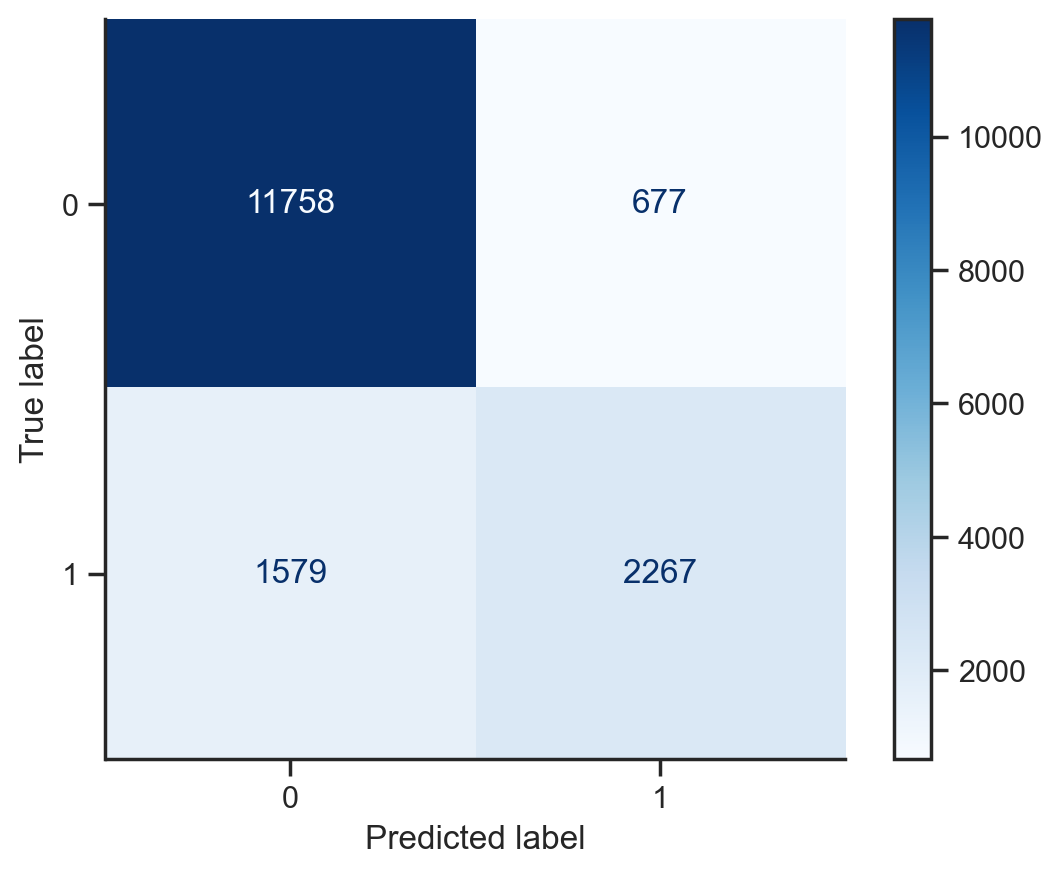

In [89]:
cm = confusion_matrix(y_test, tuned_tree_predictions)

plot = ConfusionMatrixDisplay(cm, display_labels = y.unique())

plot.plot(cmap='Blues');

#### 7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

Answer: With my tuned parameters, the accuracy of a decision tree with max_depth=10, max_features=0.9, min_sample_leafs=10 and random_state=17 is 0.861

### 3.3 (Optional) Random forest without parameter tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [90]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

Make predictions for the test data and assess accuracy.

In [91]:
forest_predictions = rf.predict(X_test)

score3 = get_score('Random Forest', y_test, forest_predictions)
score = pd.concat([score, score3], axis=0)
score

,Model,Precision,Recall,F1,Accuracy
0,Decision Tree,0.756,0.507,0.607,0.845
0,Decision Tree GridSearchCV,0.770,0.589,0.668,0.861
0,Random Forest,0.724,0.607,0.660,0.853


### 3.4 (Optional) Random forest with parameter tuning

Train a random forest **(RandomForestClassifier)**. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [101]:
forest_params = {
    'max_depth': range(10, 21),
    'max_features': range(5, 105, 20),
   # 'min_samples_split': [2, 5, 10],
   # 'min_samples_leaf': [1, 2, 4],
   # 'n_estimators': [50, 100, 200],
}

locally_best_forest = GridSearchCV(rf, forest_params, n_jobs=-1, verbose=True, cv=5)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)},
             verbose=True)

In [102]:
# Get the best parameters and best score
best_params = locally_best_forest.best_params_
best_score = locally_best_forest.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 19, 'max_features': 25}
Best Score: 0.8651148562825209


Make predictions for the test data and assess accuracy.

In [103]:
tuned_forest_predictions = locally_best_forest.predict(X_test)
score4 = get_score('Random Forest GridSearchCV', y_test, tuned_forest_predictions)
score = pd.concat([score, score4], axis=0)
score

,Model,Precision,Recall,F1,Accuracy
0,Decision Tree,0.756,0.507,0.607,0.845
0,Decision Tree GridSearchCV,0.770,0.589,0.668,0.861
0,Random Forest,0.724,0.607,0.660,0.853
0,Random Forest GridSearchCV,0.768,0.606,0.678,0.864
